In [1]:
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
import torch
from pathlib import Path
import pickle
import os

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE


import json
import pickle

2025-05-02 17:03:59.712227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746205439.918283      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746205439.969932      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Download the official MovieLens-1M dataset
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o ml-1m.zip
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', 
                        header=None, engine='python',
                        names=['userId', 'movieId', 'rating', 'timestamp'])

--2025-05-02 17:04:12--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  13.4MB/s    in 0.4s    

2025-05-02 17:04:13 (13.4 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [3]:
movies = pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv', low_memory=False)
links = pd.read_csv('/kaggle/input/the-movies-dataset/links.csv')
full_ratings = pd.read_csv("/kaggle/input/the-movies-dataset/ratings.csv")


In [4]:
# 2. Display basic info about our datasets
print("Original number of movies:", len(movies))
print("Original number of ratings:", len(ratings))
print("Number of links:", len(links))

Original number of movies: 45466
Original number of ratings: 1000209
Number of links: 45843


In [5]:
# 3. Clean up the movies dataset (remove missing overviews)
movies_cleaned = movies.dropna(subset=['overview'])
movies_cleaned = movies_cleaned[movies_cleaned['overview'].str.strip() != '']
print("Number of movies after cleaning overviews:", len(movies_cleaned))

Number of movies after cleaning overviews: 44507


In [6]:
# 4. Convert id column in movies_cleaned to numeric (these are tmdbId values)
movies_cleaned['id'] = pd.to_numeric(movies_cleaned['id'], errors='coerce')
movies_cleaned = movies_cleaned.dropna(subset=['id'])
movies_cleaned['id'] = movies_cleaned['id'].astype(int)
print("Number of movies after ID conversion:", len(movies_cleaned))

Number of movies after ID conversion: 44504


In [7]:
# 5. Ensure tmdbId in links is numeric
links['tmdbId'] = pd.to_numeric(links['tmdbId'], errors='coerce')
links = links.dropna(subset=['tmdbId'])
links['tmdbId'] = links['tmdbId'].astype(int)
print("Number of links after cleaning:", len(links))

Number of links after cleaning: 45624


In [8]:
# 6. Add movieId to the movies_cleaned dataframe by merging with links
# This is the key enhancement you requested
movies_with_movieId = pd.merge(movies_cleaned, 
                              links[['movieId', 'tmdbId']], 
                              left_on='id', 
                              right_on='tmdbId', 
                              how='left')

In [9]:
# 7. Remove movies that don't have a matching movieId
movies_with_movieId = movies_with_movieId.dropna(subset=['movieId'])
movies_with_movieId['movieId'] = movies_with_movieId['movieId'].astype(int)
print("Final number of movies with movieId:", len(movies_with_movieId))

Final number of movies with movieId: 44566


In [10]:
# 9. Now it's easy to filter ratings - just use the movieId directly
filtered_ratings = ratings[ratings['movieId'].isin(movies_with_movieId['movieId'])]
filtered_full_ratings = full_ratings[full_ratings['movieId'].isin(movies_with_movieId['movieId'])]

print(filtered_ratings.head(5))

   userId  movieId  rating  timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291


In [11]:
# 10. Check the results
print("\nResults after filtering with movieId:")
print("Original ratings count:", len(ratings))
print("Filtered ratings count:", len(filtered_ratings))

print("Remaining unique users:", filtered_ratings['userId'].nunique())
print("Original unique movies in ratings:", ratings['movieId'].nunique())
print("Remaining unique movies in ratings:", filtered_ratings['movieId'].nunique())


Results after filtering with movieId:
Original ratings count: 1000209
Filtered ratings count: 997313
Remaining unique users: 6040
Original unique movies in ratings: 3706
Remaining unique movies in ratings: 3657


In [12]:
movies_with_movieId.to_csv('/kaggle/working/movies.csv', index=False)
filtered_ratings.to_csv('/kaggle/working/ratings.csv', index=False)
filtered_full_ratings.to_csv('/kaggle/working/full_ratings.csv', index=False)

## Embedding

In [13]:
def create_book_text(row):
    overview = row.get("overview")

    text = f"{overview}"
    return text.strip()


def check_gpu():
    """Check GPU availability and print information."""
    if torch.cuda.is_available():
        print("\nGPU Information:")
        print(f"GPU Available: Yes")
        print(f"GPU Device: {torch.cuda.get_device_name(0)}")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        print(f"Current GPU Memory Usage: {torch.cuda.memory_allocated(0)/1e9:.2f} GB")
        return True
    else:
        print("\nNo GPU available, using CPU")
        return False

def embed_dataset(input_file, output_dir):
    # Check GPU availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nUsing device: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")

    # Create output directory if it doesn't exist
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Load the dataset
    print("Loading dataset...")
    df = pd.read_csv(input_file)

    # Models to use
    models = {
        'mpnet': 'sentence-transformers/all-mpnet-base-v2',
        'miniLM': 'sentence-transformers/all-MiniLM-L6-v2'
    }

    for model_name, model_path in models.items():
        print(f"\nProcessing with {model_name}...")

        model = SentenceTransformer(model_path)

        print("Creating book texts...")
        book_texts = df.apply(create_book_text, axis=1).tolist()

        print("Creating embeddings...")
        batch_size = 1024
        embeddings = []

        for i in range(0, len(book_texts), batch_size):
            batch = book_texts[i:i + batch_size]
            batch_embeddings = model.encode(batch,
                                            show_progress_bar=True,
                                            normalize_embeddings=True)
            embeddings.extend(batch_embeddings)

        embeddings = np.array(embeddings)

        # Save embeddings and related data
        print(f"Saving {model_name} embeddings...")

        # Save embeddings
        embedding_file = output_dir / f'{model_name}_embeddings_overview.pkl'
        with open(embedding_file, 'wb') as f:
            pickle.dump({
                'embeddings': embeddings,
                'movieId': df['movieId'].tolist(),
                'model_name': model_path
            }, f)

        print(f"Embeddings saved to {embedding_file}")
        print(f"Embedding shape: {embeddings.shape}")

        # Free up GPU memory
        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

In [14]:
movies_file = os.path.join("/kaggle/working/movies.csv")
embeddings_dir = "/kaggle/working/"


# Check GPU status
check_gpu()

embed_dataset(movies_file, embeddings_dir)

print("Embeddings generation completed successfully!")


GPU Information:
GPU Available: Yes
GPU Device: Tesla P100-PCIE-16GB
Number of GPUs: 1
Current GPU Memory Usage: 0.00 GB

Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory Allocated: 0.00 GB
Loading dataset...

Processing with mpnet...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Creating book texts...
Creating embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Saving mpnet embeddings...
Embeddings saved to /kaggle/working/mpnet_embeddings_overview.pkl
Embedding shape: (44566, 768)

Processing with miniLM...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Creating book texts...
Creating embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Saving miniLM embeddings...
Embeddings saved to /kaggle/working/miniLM_embeddings_overview.pkl
Embedding shape: (44566, 384)
Embeddings generation completed successfully!


In [15]:
# Load embeddings and movie data
def load_data(embs_path, movies_path):
    # Load embeddings
    with open(embs_path, 'rb') as f:
        embedding_data = pickle.load(f)
    
    # Load movie metadata (already contains movieId from previous processing)
    movies_df = pd.read_csv(movies_path)
    
    # Verify the movies_df has the movieId column
    if 'movieId' not in movies_df.columns:
        raise ValueError("The movies dataframe does not contain a 'movieId' column. "
                         "Make sure you're using the processed version with added movieId.")
    
    return embedding_data, movies_df

# Test 1: Find similar movies to a query movie
def find_similar_movies(movie_title, embedding_data, movies_df, top_n=5):
    # Get embeddings and movieIds
    embeddings = embedding_data['embeddings']
    movie_id_list = embedding_data['movieId']
    
    # Find the movie by title (case insensitive partial match)
    query_movie = movies_df[movies_df['original_title'].str.contains(movie_title, case=False, na=False)]
    
    if len(query_movie) == 0:
        print(f"No movie found with title containing '{movie_title}'")
        return None
    
    # Use the first match if multiple found
    query_movie = query_movie.iloc[0]
    print(f"Query movie: {query_movie['original_title']} ({query_movie['release_date']})")
    
    # Get the movieId for the query movie
    query_movieId = query_movie['movieId']  # Using movieId directly now
    print(f"MovieId: {query_movieId}")
    
    # Check if this movieId exists in our embeddings
    if query_movieId not in movie_id_list:
        print(f"No embedding found for movie with ID {query_movieId}")
        return None
    
    # Find the index of the query movie in our embeddings
    query_idx = movie_id_list.index(query_movieId)
    query_embedding = embeddings[query_idx]
    
    # Calculate similarity to all other movies
    similarities = cosine_similarity([query_embedding], embeddings)[0]
    
    # Create a list of (movie_index, similarity) tuples
    movie_similarities = [(i, similarities[i]) for i in range(len(similarities))]
    
    # Sort by similarity in descending order and get top matches (excluding the query movie)
    movie_similarities.sort(key=lambda x: x[1], reverse=True)
    top_matches = [x for x in movie_similarities if movie_id_list[x[0]] != query_movieId][:top_n]
    
    # Display results
    print(f"\nTop {top_n} similar movies:")
    for idx, sim in top_matches:
        similar_movieId = movie_id_list[idx]
        # Find this movie in the movies dataframe using movieId
        similar_movie = movies_df[movies_df['movieId'] == similar_movieId]
        if len(similar_movie) > 0:
            similar_movie = similar_movie.iloc[0]
            print(f"Similarity: {sim:.4f} - '{similar_movie['original_title']}' ({similar_movie['release_date']})")
        else:
            print(f"Similarity: {sim:.4f} - Movie ID {similar_movieId} not found in metadata")
    
    return top_matches

# Test 2: Visualize embeddings with t-SNE
def visualize_embeddings(embedding_data, movies_df, sample_size=40000, model_name=""):
    print("Preparing visualization of movie embeddings...")
    
    # Get a sample of embeddings to visualize (t-SNE can be slow with large datasets)
    embeddings = embedding_data['embeddings']
    movie_id_list = embedding_data['movieId']
    
    if len(embeddings) > sample_size:
        indices = np.random.choice(len(embeddings), sample_size, replace=False)
        sample_embeddings = embeddings[indices]
        sample_movieIds = [movie_id_list[i] for i in indices]
    else:
        sample_embeddings = embeddings
        sample_movieIds = movie_id_list
    
    # Apply t-SNE for dimensionality reduction
    print("Running t-SNE dimensionality reduction...")
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(sample_embeddings)
    
    # Create a dataframe for plotting
    plot_df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'movieId': sample_movieIds
    })
    
    # Merge with movie information - now using movieId directly
    plot_df = plot_df.merge(movies_df[['movieId', 'original_title', 'genres']], 
                          on='movieId', how='left')
    
    # Plot the embeddings
    plt.figure(figsize=(12, 10))
    plt.scatter(plot_df['x'], plot_df['y'], alpha=0.5, s=10)
    title = f'Movie Embedding Visualization (t-SNE)'
    if model_name:
        title = f'{model_name} - {title}'
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.tight_layout()
    filename = f'embedding_visualization_{model_name.lower().replace("-", "_") if model_name else "default"}.png'
    plt.savefig(filename)
    plt.show()
    
    return plot_df

# Main function to run the sanity tests
def run_embedding_sanity_tests():
    # Paths to data files
    mp_net_embs_path = "/kaggle/working/mpnet_embeddings_overview.pkl"
    mini_llm_embs_path = "/kaggle/working/miniLM_embeddings_overview.pkl"
    movies_path = '/kaggle/working/movies.csv'
    
    # Test with MPNet embeddings
    print("\n===== Testing with MPNet Embeddings =====\n")
    mpnet_embedding_data, movies_df = load_data(mp_net_embs_path, movies_path)
    
    # Test 1: Find similar movies for a few popular titles
    test_movies = ["Toy Story", "The Matrix", "Inception"]
    for movie in test_movies:
        find_similar_movies(movie, mpnet_embedding_data, movies_df)
        print("\n" + "-"*50 + "\n")
    
    # Test 2: Visualize embeddings
    mpnet_plot_df = visualize_embeddings(mpnet_embedding_data, movies_df, model_name="MPNet")
    
    # Test with MiniLM embeddings
    print("\n===== Testing with MiniLM Embeddings =====\n")
    minilm_embedding_data, movies_df = load_data(mini_llm_embs_path, movies_path)
    
    # Test 1: Find similar movies for a few popular titles
    for movie in test_movies:
        find_similar_movies(movie, minilm_embedding_data, movies_df)
        print("\n" + "-"*50 + "\n")
    
    # Test 2: Visualize embeddings
    minilm_plot_df = visualize_embeddings(minilm_embedding_data, movies_df, model_name="MiniLM")
    
    return {
        "mpnet": {"data": mpnet_embedding_data, "plot": mpnet_plot_df}, 
        "minilm": {"data": minilm_embedding_data, "plot": minilm_plot_df},
        "movies_df": movies_df
    }


===== Testing with MPNet Embeddings =====

Query movie: Toy Story (1995-10-30)
MovieId: 1

Top 5 similar movies:
Similarity: 0.8330 - 'Toy Story 3' (2010-06-16)
Similarity: 0.8170 - 'Toy Story 2' (1999-10-30)
Similarity: 0.5339 - 'Welcome to Happiness' (2015-04-27)
Similarity: 0.4821 - 'Child's Play 3' (1991-08-30)
Similarity: 0.4819 - 'Elf' (2003-10-09)

--------------------------------------------------

Query movie: The Matrix (1999-03-30)
MovieId: 2571

Top 5 similar movies:
Similarity: 0.6657 - 'The Matrix Revisited' (2001-11-19)
Similarity: 0.5762 - 'All Watched Over by Machines of Loving Grace' (2011-06-06)
Similarity: 0.5722 - 'The Matrix Revolutions' (2003-11-05)
Similarity: 0.5665 - '23' (1998-07-02)
Similarity: 0.5611 - 'The Imitation Game' (2014-11-14)

--------------------------------------------------

Query movie: Inception (2010-07-14)
MovieId: 79132

Top 5 similar movies:
Similarity: 0.5676 - 'Extracted' (2012-03-10)
Similarity: 0.5431 - 'Awaara' (1951-04-07)
Similari

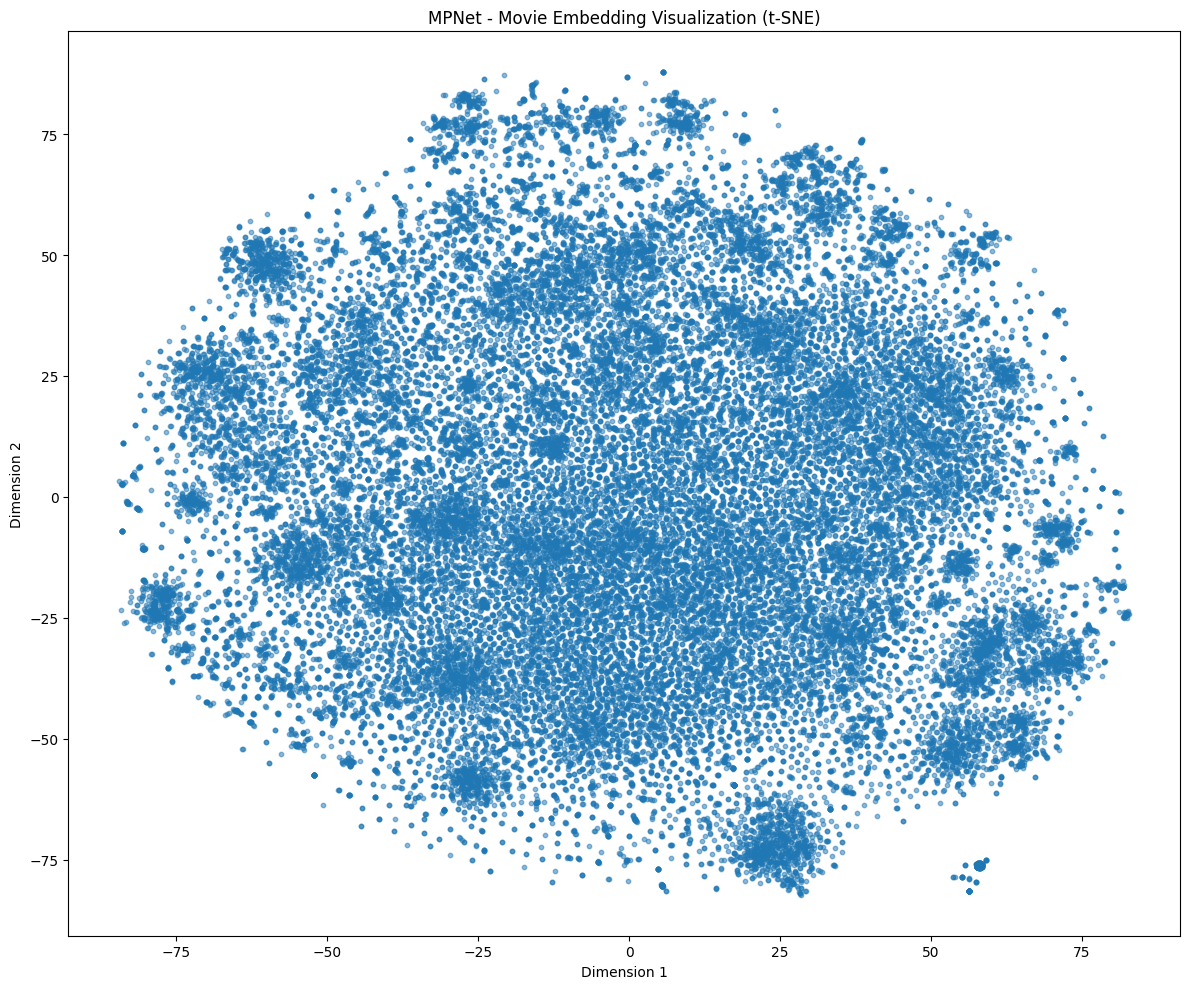


===== Testing with MiniLM Embeddings =====

Query movie: Toy Story (1995-10-30)
MovieId: 1

Top 5 similar movies:
Similarity: 0.7586 - 'Toy Story 3' (2010-06-16)
Similarity: 0.7401 - 'Toy Story 2' (1999-10-30)
Similarity: 0.5037 - 'Welcome to Happiness' (2015-04-27)
Similarity: 0.4649 - 'Child's Play 3' (1991-08-30)
Similarity: 0.4427 - '玩具修理者' (2002-01-01)

--------------------------------------------------

Query movie: The Matrix (1999-03-30)
MovieId: 2571

Top 5 similar movies:
Similarity: 0.6604 - 'A Detective Story' (2003-04-01)
Similarity: 0.6090 - '23' (1998-07-02)
Similarity: 0.5921 - 'Algorithm' (2014-07-19)
Similarity: 0.5564 - 'Commando' (1985-10-03)
Similarity: 0.5454 - 'The Matrix Reloaded' (2003-05-15)

--------------------------------------------------

Query movie: Inception (2010-07-14)
MovieId: 79132

Top 5 similar movies:
Similarity: 0.4941 - 'House' (1986-02-28)
Similarity: 0.4851 - 'Nowhere to Go' (1958-12-02)
Similarity: 0.4781 - 'Identity Thief' (2013-02-07)
Si

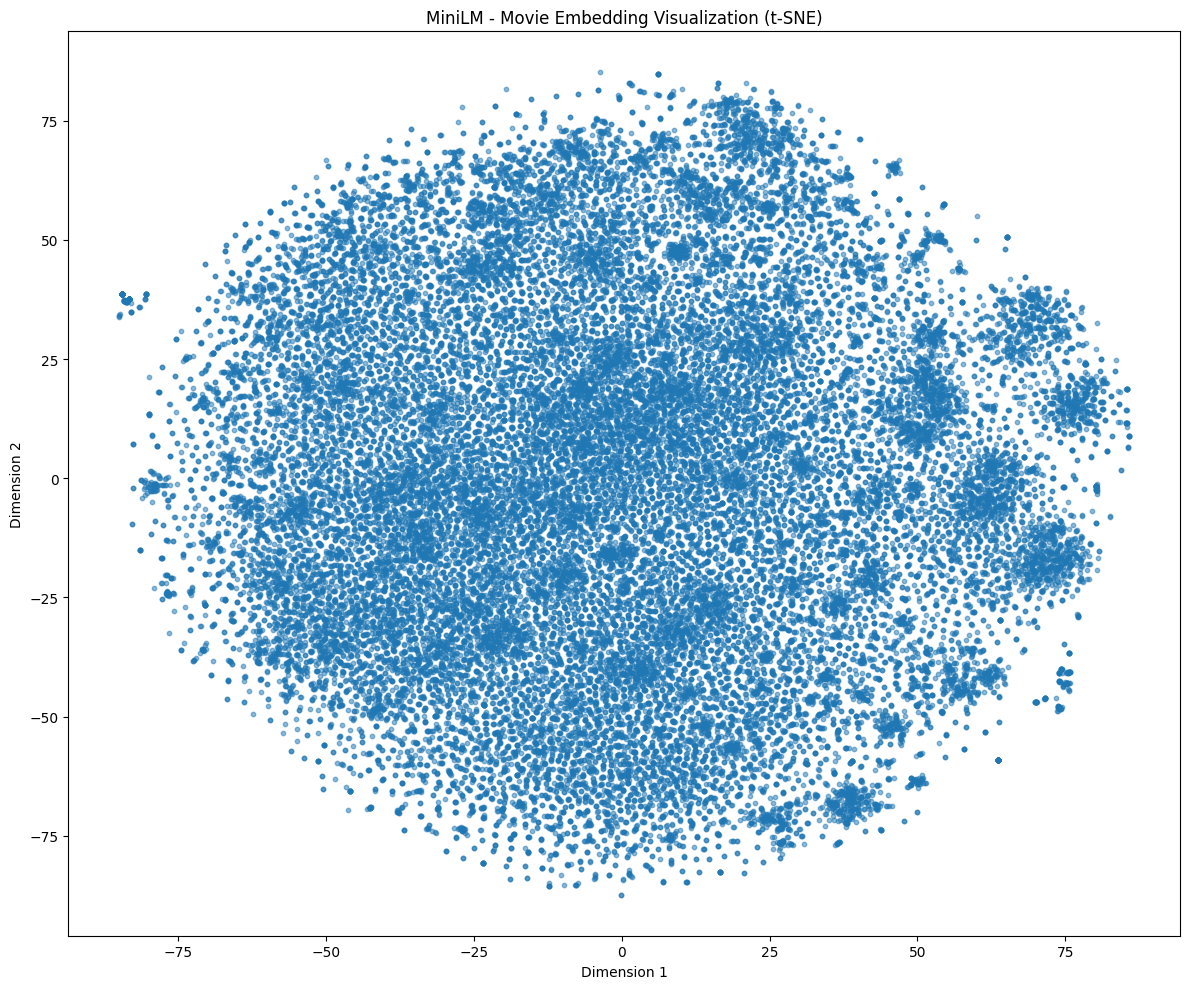

In [16]:
results = run_embedding_sanity_tests()

In [17]:
def create_genre_encoding(movies_df, save_path=None):
    # Extract all genres from the movies
    all_genres = set()
    parsed_genres = {}
    
    for idx, row in movies_df.iterrows():
        movie_id = row['movieId']
        genre_data = row['genres']
        
        # Skip if no genre data
        if pd.isna(genre_data) or genre_data == '':
            parsed_genres[movie_id] = []
            continue
        
        # Parse the genre string into a list of dictionaries
        try:
            # First, make sure single quotes are converted to double quotes for proper JSON parsing
            if isinstance(genre_data, str):
                # Replace single quotes with double quotes, handle edge cases
                cleaned_str = genre_data.replace("'", '"')
                genres_list = json.loads(cleaned_str)
            else:
                # If it's already a list (not a string)
                genres_list = genre_data
                
            # Extract the genre names
            genres = [g['name'] for g in genres_list if 'name' in g]
            parsed_genres[movie_id] = genres
            all_genres.update(genres)
            
        except (json.JSONDecodeError, TypeError, ValueError) as e:
            print(f"Error parsing genres for movie {movie_id}: {e}")
            print(f"Genre data: {genre_data}")
            parsed_genres[movie_id] = []
    
    all_genres = sorted(list(all_genres))
    print(f"Found {len(all_genres)} unique genres")
    
    # Create one-hot vectors for each movie
    genre_vectors = {}
    for movie_id, genres in parsed_genres.items():
        # Initialize vector of zeros
        vector = np.zeros(len(all_genres))
        
        # Set 1 for each genre the movie has
        for genre in genres:
            if genre in all_genres:  # Safety check
                genre_idx = all_genres.index(genre)
                vector[genre_idx] = 1
        
        genre_vectors[movie_id] = vector
    
    print(f"Created genre vectors for {len(genre_vectors)} movies")
    
    # Save the genre vectors and genre list if a path is provided
    if save_path:
        save_genre_encodings(genre_vectors, all_genres, save_path)
    
    return genre_vectors, all_genres

def save_genre_encodings(genre_vectors, all_genres, save_path):

    # Create the directory if it doesn't exist
    save_dir = Path(save_path).parent
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Package the data
    genre_data = {
        'genre_vectors': genre_vectors,
        'all_genres': all_genres
    }
    
    # Save to file
    with open(save_path, 'wb') as f:
        pickle.dump(genre_data, f)
    
    print(f"Genre encodings saved to {save_path}")


def load_genre_encodings(load_path):
    with open(load_path, 'rb') as f:
        genre_data = pickle.load(f)
    
    genre_vectors = genre_data['genre_vectors']
    all_genres = genre_data['all_genres']
    
    print(f"Loaded genre encodings for {len(genre_vectors)} movies with {len(all_genres)} genres")
    
    return genre_vectors, all_genres


In [18]:
def create_language_encoding(movies_df, save_path=None):
    # Extract all languages from the movies
    all_languages = set()
    parsed_languages = {}

    for idx, row in movies_df.iterrows():
        movie_id = row['movieId']
        language_code = row.get('original_language', None)

        # Skip if no language data
        if pd.isna(language_code) or language_code == '':
            parsed_languages[movie_id] = 'unknown'
            all_languages.add('unknown')
            continue

        # Store the language code
        parsed_languages[movie_id] = language_code
        all_languages.add(language_code)

    all_languages = sorted(list(all_languages))
    print(f"Found {len(all_languages)} unique language codes")

    # Create one-hot vectors for each movie
    language_vectors = {}
    for movie_id, language in parsed_languages.items():
        # Initialize vector of zeros
        vector = np.zeros(len(all_languages))

        # Set 1 for the movie's language
        lang_idx = all_languages.index(language)
        vector[lang_idx] = 1

        language_vectors[movie_id] = vector

    print(f"Created language vectors for {len(language_vectors)} movies")

    # Save the language vectors and language list if a path is provided
    if save_path:
        save_language_encodings(language_vectors, all_languages, save_path)

    return language_vectors, all_languages

def save_language_encodings(language_vectors, all_languages, save_path):
    # Create the directory if it doesn't exist
    save_dir = Path(save_path).parent
    save_dir.mkdir(parents=True, exist_ok=True)

    # Package the data
    language_data = {
        'language_vectors': language_vectors,
        'all_languages': all_languages
    }

    # Save to file
    with open(save_path, 'wb') as f:
        pickle.dump(language_data, f)

    print(f"Language encodings saved to {save_path}")

def load_language_encodings(load_path):
    with open(load_path, 'rb') as f:
        language_data = pickle.load(f)

    language_vectors = language_data['language_vectors']
    all_languages = language_data['all_languages']

    print(f"Loaded language encodings for {len(language_vectors)} movies with {len(all_languages)} language codes")

    return language_vectors, all_languages

In [19]:
movies_df = pd.read_csv('/kaggle/working/movies.csv')


genre_vectors, all_genres = create_genre_encoding(
    movies_df, 
    save_path="/kaggle/working/genre_encodings.pkl"
)

language_vectors, all_languages = create_language_encoding(
    movies_df,
    save_path="/kaggle/working/language_encodings.pkl"
)


Found 20 unique genres
Created genre vectors for 44504 movies
Genre encodings saved to /kaggle/working/genre_encodings.pkl
Found 90 unique language codes
Created language vectors for 44504 movies
Language encodings saved to /kaggle/working/language_encodings.pkl


In [20]:
def create_combined_embeddings(overview_emb_path, genre_vectors, all_genres, genre_weight=0.3,
                           language_vectors=None, language_weight=0.1):
    # Adjust weights if language vectors are provided
    overview_weight = 1.0 - genre_weight
    if language_vectors is not None:
        overview_weight = 1.0 - genre_weight - language_weight

    # Load overview embeddings
    with open(overview_emb_path, 'rb') as f:
        overview_data = pickle.load(f)

    overview_embeddings = overview_data['embeddings']
    movie_id_list = overview_data['movieId']

    # Create combined embeddings
    combined_embeddings = []
    combined_movie_ids = []

    for idx, movie_id in enumerate(movie_id_list):
        # Skip if movie has no genre vector
        if movie_id not in genre_vectors:
            continue

        # Skip if using language vectors but movie has no language vector
        if language_vectors is not None and movie_id not in language_vectors:
            continue

        # Get embeddings (MPNet embeddings are already normalized)
        overview_emb = overview_embeddings[idx]
        genre_emb = genre_vectors[movie_id]

        # Only normalize genre embeddings
        if np.sum(genre_emb) > 0:
            genre_norm = genre_emb / np.linalg.norm(genre_emb)
        else:
            genre_norm = genre_emb

        # If using language vectors, get and normalize them
        if language_vectors is not None:
            language_emb = language_vectors[movie_id]
            if np.sum(language_emb) > 0:
                language_norm = language_emb / np.linalg.norm(language_emb)
            else:
                language_norm = language_emb

            # Concatenate all three with weighting
            combined = np.concatenate([
                overview_weight * overview_emb,  # Already normalized from MPNet
                genre_weight * genre_norm,
                language_weight * language_norm
            ])
        else:
            # Concatenate just overview and genre with weighting
            combined = np.concatenate([
                overview_weight * overview_emb,  # Already normalized from MPNet
                genre_weight * genre_norm
            ])

        # Normalize final vector to ensure proper similarity calculation
        combined = combined / np.linalg.norm(combined)

        combined_embeddings.append(combined)
        combined_movie_ids.append(movie_id)

    print(f"Created combined embeddings for {len(combined_embeddings)} movies")

    # Package the data
    model_name = f"combined_{overview_data.get('model_name', 'overview')}+genre_{genre_weight}"
    if language_vectors is not None:
        model_name += f"+language_{language_weight}"

    combined_data = {
        'embeddings': np.array(combined_embeddings),
        'movieId': combined_movie_ids,
        'model_name': model_name,
        'normalized': True,  # Flag to indicate embeddings are normalized
        'weights': {
            'overview': overview_weight,
            'genre': genre_weight,
            'language': language_weight if language_vectors is not None else 0.0
        }
    }

    return combined_data

def save_combined_embeddings(combined_data, save_path):
    with open(save_path, 'wb') as f:
        pickle.dump(combined_data, f)

    print(f"Combined embeddings saved to {save_path}")


In [21]:
def run_combined_embeddings_tests(genre_encodings_path, movies_path, language_encodings_path=None):
    mp_net_embs_path = "/kaggle/working/mpnet_embeddings_overview.pkl"
    
    with open(genre_encodings_path, 'rb') as f:
        genre_data = pickle.load(f)
    genre_vectors = genre_data['genre_vectors']
    all_genres = genre_data['all_genres']
    print(f"Loaded genre encodings with {len(all_genres)} genres for {len(genre_vectors)} movies")


    language_vectors = None

    
    if language_encodings_path is not None:
        with open(language_encodings_path, 'rb') as f:
            language_data = pickle.load(f)
        language_vectors = language_data['language_vectors']
        all_languages = language_data['all_languages']


    # 3. Create combined embeddings
    combined_data = create_combined_embeddings(
        mp_net_embs_path,
        genre_vectors,
        all_genres,
        genre_weight=0.3,
        language_vectors=language_vectors,
        language_weight=0.1
    )
    if language_vectors is not None:
        save_path = "/kaggle/working/mpnet_genre_language_combined_embeddings.pkl"

    else:
        save_path = "/kaggle/working/mpnet_genre_combined_embeddings.pkl"

    save_combined_embeddings(combined_data, save_path)
    
    # 5. Load movies dataframe
    movies_df = pd.read_csv(movies_path)
    
    # 6. Test with Combined Embeddings
    print("\n===== Testing with Combined MPNet+Genre Embeddings =====\n")
    
    # 7. Find similar movies for a few popular titles
    test_movies = ["Toy Story", "The Matrix", "Inception" ,"Parasite", "Pan's Labyrinth"]
    for movie in test_movies:
        # Use the existing find_similar_movies function
        # It works because combined_data has the same structure as regular embedding data
        find_similar_movies(movie, combined_data, movies_df, 10)
        print("\n" + "-"*50 + "\n")

    model_name = "MPNet+Genre+Language" if language_vectors is not None else "MPNet+Genre"

    combined_plot_df = visualize_embeddings(combined_data, movies_df, model_name=model_name)

    
    return {
        "combined": {"data": combined_data, "plot": combined_plot_df},
        "movies_df": movies_df
    }

Loaded genre encodings with 20 genres for 44504 movies
Created combined embeddings for 44566 movies
Combined embeddings saved to /kaggle/working/mpnet_genre_combined_embeddings.pkl

===== Testing with Combined MPNet+Genre Embeddings =====

Query movie: Toy Story (1995-10-30)
MovieId: 1

Top 10 similar movies:
Similarity: 0.8589 - 'Toy Story 3' (2010-06-16)
Similarity: 0.8454 - 'Toy Story 2' (1999-10-30)
Similarity: 0.5566 - 'Mickey's Once Upon a Christmas' (1999-12-07)
Similarity: 0.5467 - 'Charlie Brown's Christmas Tales' (2002-12-08)
Similarity: 0.5354 - 'Toy Story of Terror!' (2013-10-15)
Similarity: 0.5330 - 'Pluto's Christmas Tree' (1952-11-21)
Similarity: 0.5274 - 'Pinocchio' (1940-02-23)
Similarity: 0.5241 - 'Hawaiian Vacation' (2011-06-16)
Similarity: 0.5132 - 'Mickey's Twice Upon a Christmas' (2004-01-01)
Similarity: 0.5106 - 'Elf' (2003-10-09)

--------------------------------------------------

Query movie: The Matrix (1999-03-30)
MovieId: 2571

Top 10 similar movies:
Simila

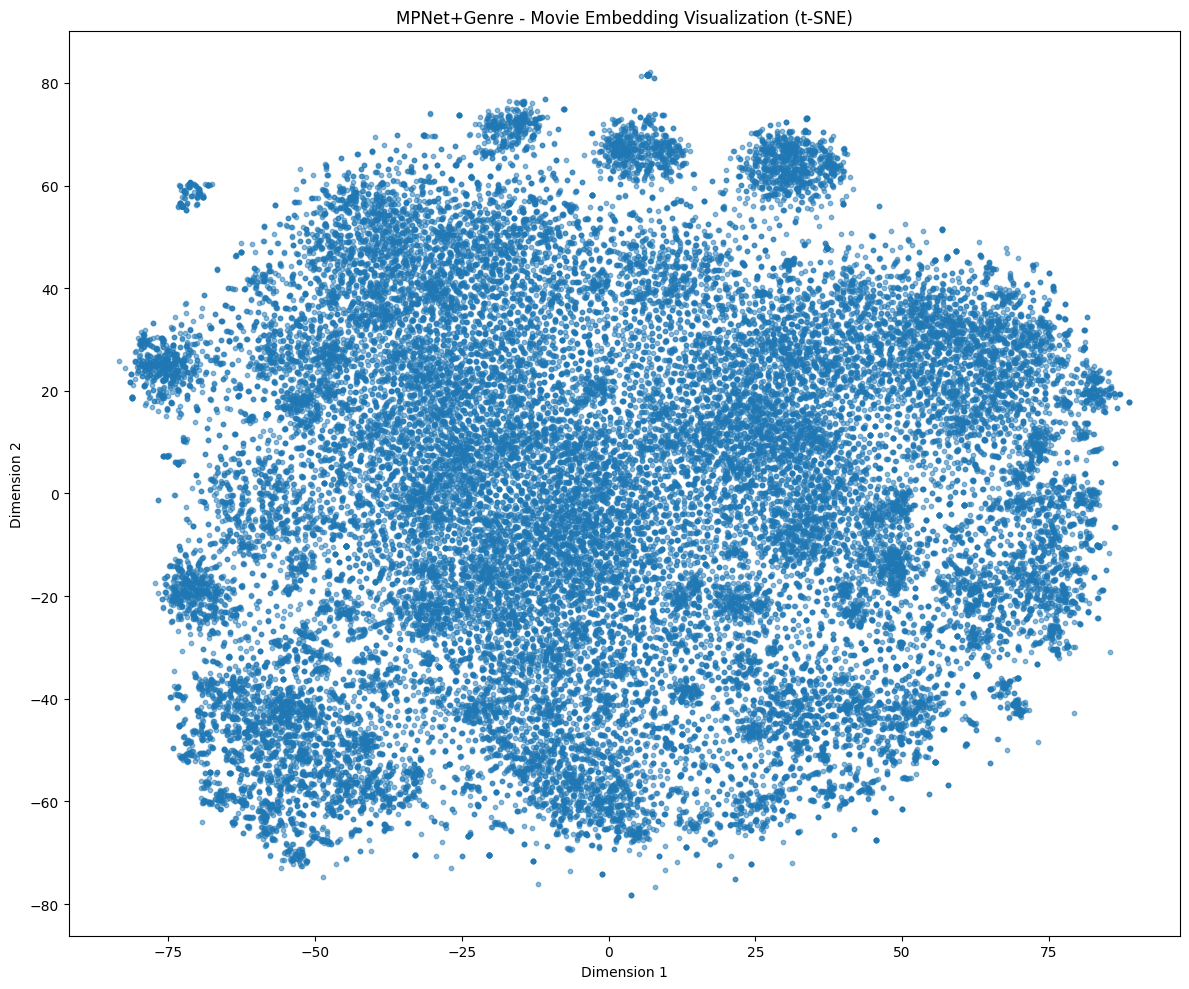

In [22]:
results = run_combined_embeddings_tests(
    genre_encodings_path="/kaggle/working/genre_encodings.pkl",
    movies_path='/kaggle/working/movies.csv'
)

Loaded genre encodings with 20 genres for 44504 movies
Created combined embeddings for 44566 movies
Combined embeddings saved to /kaggle/working/mpnet_genre_language_combined_embeddings.pkl

===== Testing with Combined MPNet+Genre Embeddings =====

Query movie: Toy Story (1995-10-30)
MovieId: 1

Top 10 similar movies:
Similarity: 0.8693 - 'Toy Story 3' (2010-06-16)
Similarity: 0.8567 - 'Toy Story 2' (1999-10-30)
Similarity: 0.5893 - 'Mickey's Once Upon a Christmas' (1999-12-07)
Similarity: 0.5801 - 'Charlie Brown's Christmas Tales' (2002-12-08)
Similarity: 0.5696 - 'Toy Story of Terror!' (2013-10-15)
Similarity: 0.5579 - 'Pluto's Christmas Tree' (1952-11-21)
Similarity: 0.5527 - 'Pinocchio' (1940-02-23)
Similarity: 0.5496 - 'Hawaiian Vacation' (2011-06-16)
Similarity: 0.5395 - 'Mickey's Twice Upon a Christmas' (2004-01-01)
Similarity: 0.5293 - 'Elf' (2003-10-09)

--------------------------------------------------

Query movie: The Matrix (1999-03-30)
MovieId: 2571

Top 10 similar movie

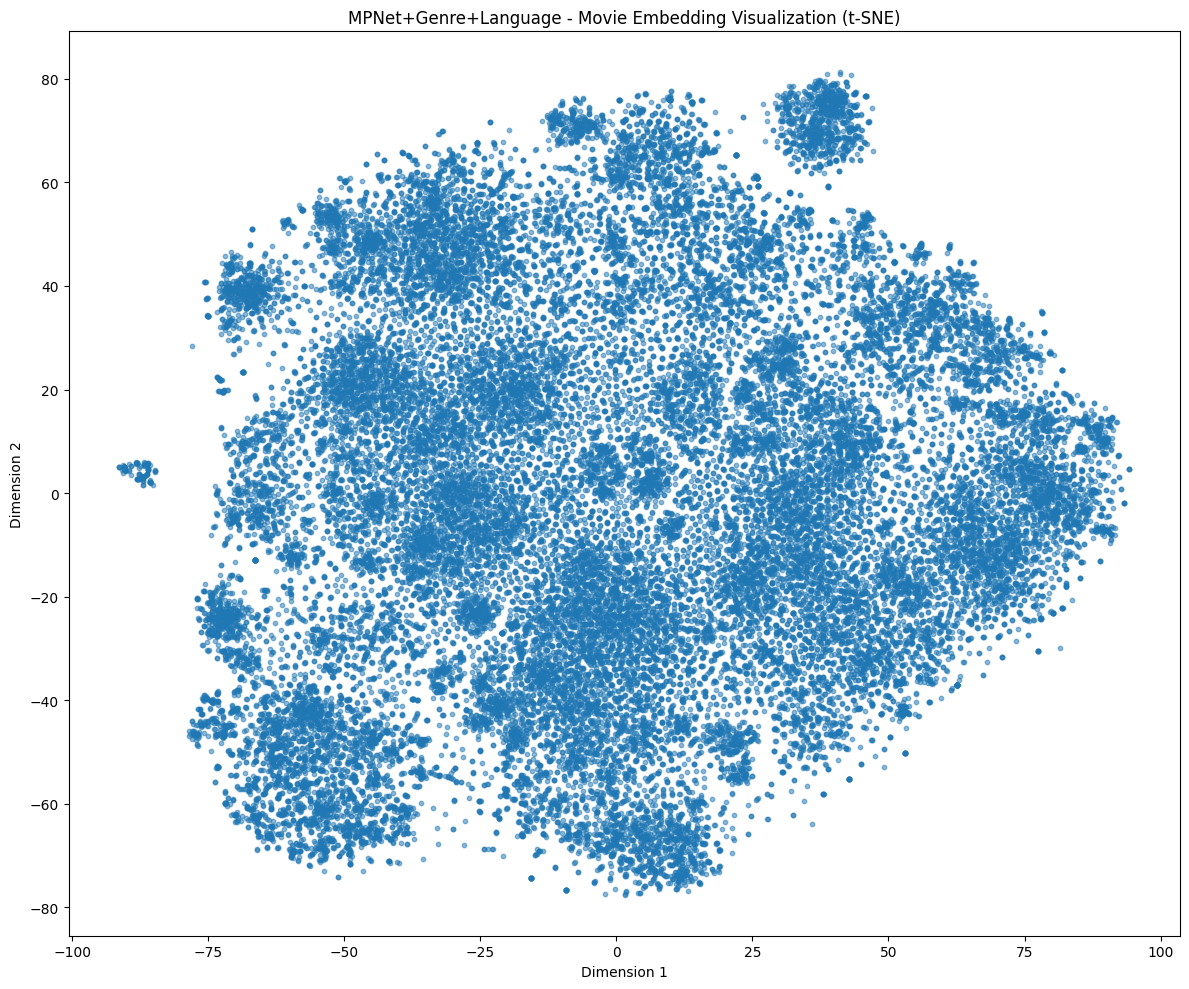

In [23]:
results = run_combined_embeddings_tests(
    genre_encodings_path="/kaggle/working/genre_encodings.pkl",
    language_encodings_path="/kaggle/working/language_encodings.pkl",
    movies_path='/kaggle/working/movies.csv'
)